## Loading of Steinmetz data

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [2]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [3]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

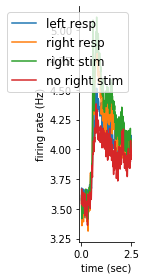

In [4]:
#@title basic plots of population average
from matplotlib import pyplot as plt
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

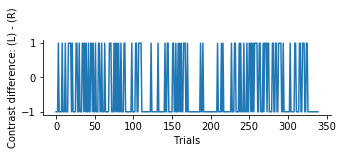

(340,)


In [5]:
#Encode stimulus onset into spike trains using a Poisson GLM

#Make contrast matrix
cL = dat['contrast_left']; cR = dat['contrast_right'];
cdiff = 2*((cL - cR)>0)-1;

f=plt.figure(figsize=(5,2))
plt.plot(cdiff); plt.xlabel('Trials'); plt.ylabel('Contrast difference: (L) - (R)'); plt.show()
print(cdiff.shape)

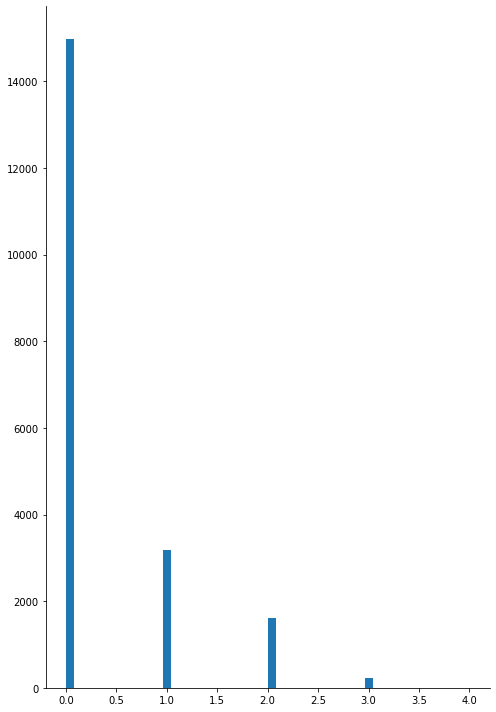

In [98]:
import pickle
tut_data = pickle.load(open("stim_spike_from_W1D4_Tut1.dat", "rb")); 
stim=tut_data[0]; spikes=tut_data[1];

f=plt.figure(figsize=(7,10))
# plt.subplot(2,1,1); plt.plot(stim); 
# plt.subplot(2,1,2); plt.plot(spikes);
plt.hist(spikes,bins=50);

In [89]:
def plot_spikes_with_prediction(
    spikes, predicted_spikes, dt, nt=50, t0=120, **kws):
  """Plot actual and predicted spike counts.

  Args:
    spikes (1D array): Vector of actual spike counts
    predicted_spikes (1D array): Vector of predicted spike counts
    dt (number): Duration of each time bin.
    nt (number): Number of time bins to plot
    t0 (number): Index of first time bin to plot.
    kws: Pass additional keyword arguments to plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots()
  lines = ax.stem(t, spikes[:nt], use_line_collection=True)
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_spikes[:nt], **kws)
  ax.set(
      xlabel="Time (s)",
      ylabel="Spikes",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["Spikes", "Predicted"])

  plt.show()

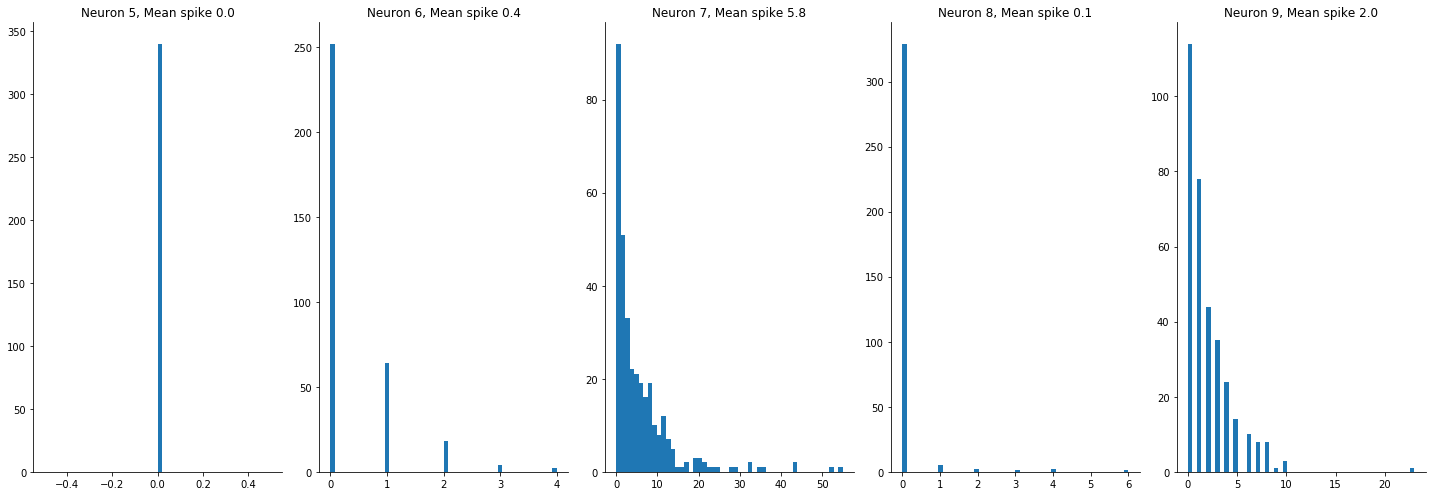

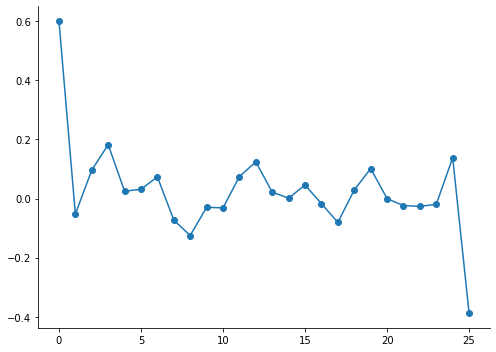

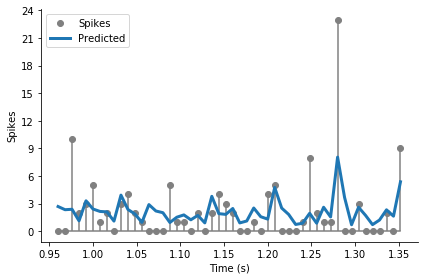

In [151]:
import pdb
from scipy.optimize import minimize
def make_design_matrix(stim,d):
    try:
        padded_stim = np.concatenate([np.zeros(d - 1), stim]);
    except:
        print('Fuck')
        pdb.set_trace()
    T = len(stim)  # Total number of timepoints (hint: total number of stimulus frames)
    X = np.zeros((T, d))
    for t in range(T):
        X[t] = padded_stim[t:t+d];

    return X
    
def neg_log_like(theta,X,y):
#      Args:
#     theta (1D array): Parameter vector.
#     X (2D array): Full design matrix.
#     y (1D array): Data values. Number of spikes for each trial
    
    rate = np.exp(X@theta);
    log_lik = y @ np.log(rate) - np.ones_like(y)@rate;
    return -log_lik;

def fit_lnp(stim,spikes,d):
    y = spikes
    constant = np.ones_like(y)
    
#     pdb.set_trace();
    X = np.column_stack([constant, make_design_matrix(stim,d)])

    # Use a random vector of weights to start (mean 0, sd .2)
    theta0 = np.random.normal(0, .2, d + 1)

    # Find parameters that minmize the negative log likelihood function
    res = minimize(neg_log_like, theta0, args=(X, y))

    return res["x"]

def predict_spike_counts_lnp(stim,spikes,d,theta=None):
    y = spikes
    constant = np.ones_like(spikes)
    
    if theta is None:
        theta = fit_lnp(stim,y,d)
    
    #Make X again to compute predicted spikes
    X = np.column_stack([constant, make_design_matrix(stim,d)])
    yhat = np.exp(X @ theta);
    return yhat

f=plt.figure(figsize=(20,7));
start=5;
for which_neuron in range(start,start+5): # encoding from stimulus -> #(spikes) is done for every neuron individually
    d = 25; #Number of points before current time to make linear filter 
    spikes = np.transpose(np.sum(dat['spks'],axis=2))[:,which_neuron];
    plt.subplot(1,5,which_neuron+1-start); plt.hist(spikes,bins=50);
    plt.title(f'Neuron {which_neuron:d}, Mean spike {np.mean(spikes):.1f}')


stim_new = cdiff; spikes_new = np.transpose(np.sum(dat['spks'],axis=2))[:,9]; 
# for ibin in range(25):
#         spikes_new[itrial,ineuron,ibin] = np.sum(dat['spks'][:,:,ibin*10:(ibin+1)*10]); 
        
# print(spikes_new[0][0])
theta = fit_lnp(stim_new, spikes_new, d); f = plt.figure(figsize=(7,5)); plt.plot(theta,'o-'); 
yhat = predict_spike_counts_lnp(stim_new, spikes_new,d);

plot_spikes_with_prediction(spikes_new,yhat,dt=0.008)


# f = plt.figure(figsize=(7,5)); kk=np.mean(np.sum(dat['spks'],axis=2)),axis=1; print(kk.shape)

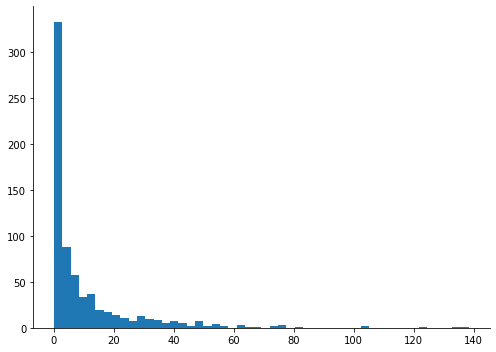

In [145]:
f = plt.figure(figsize=(7,5)); plt.hist(np.mean(np.sum(dat['spks'],axis=2),axis=1),bins=50); 

## Run dimension reduction and decoding decisions

## Dimension Reduction

In [6]:
# prepare input data

all_spikes = dat['spks']
print('neurons, trials, time_bins: ', all_spikes.shape)
# neurons, trials, time_bins
NN = all_spikes.shape[0] # number of neurons
N_trials = all_spikes.shape[1] # number of trials
N_time = all_spikes.shape[2] # number of time_bins



neurons, trials, time_bins:  (698, 340, 250)


In [7]:

go_cues = dat['gocue']
print('go_cues: ', go_cues.shape)

response_times = dat['response_time']
print('response_times: ', response_times.shape)

# get the max time length
stim_onset = 51
max_len = int(np.ceil(100*np.max(go_cues))) + stim_onset
print(max_len)

data = np.reshape(all_spikes[:,:,stim_onset:max_len], (NN, -1)).T 
print(data.shape)


go_cues:  (340, 1)
response_times:  (340, 1)
131
(27200, 698)


### DR - ICA

In [8]:
# use ICA 

from sklearn.decomposition import FastICA

transformer = FastICA(n_components=3, random_state=0)
X_transformed = transformer.fit_transform(data)
print(X_transformed.shape)


(27200, 3)


## Decoding decision

In [9]:
# prepare the y labels for the x input

choice_responses = dat['response']
print(choice_responses.shape)

print('left trials: ', len(np.where(choice_responses < 0)[0]))
print('right trials: ', len(np.where(choice_responses > 0)[0]))
print('no response trials: ', len(np.where(choice_responses == 0)[0]))

idxs = np.where(choice_responses < 0)[0]
idxs = np.append(idxs, np.where(choice_responses > 0)[0])

Y = choice_responses[idxs]
print(Y.shape)


(340,)
left trials:  141
right trials:  135
no response trials:  64
(276,)


## Linear Discriminant Analysis


[1.]
0.875


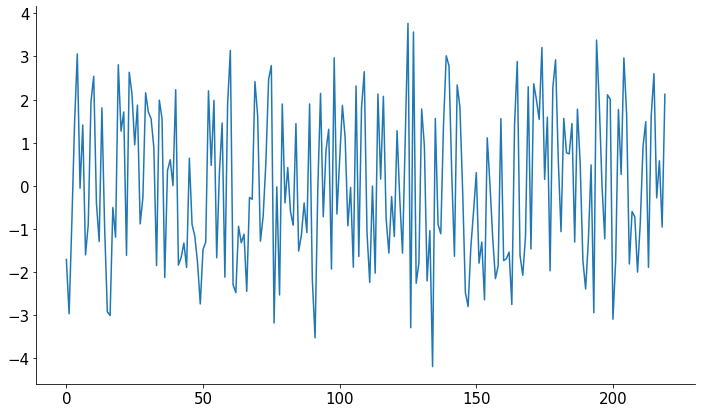

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# gocue = (np.ceil((dat['gocue']*100)))
# end_bin = np.int(np.max(gocue))

# spike_data = np.reshape(dat['spks'][:,idxs,51:51+end_bin], (NN,-1))  #shape is neurons by time and trials
# spike_data = spike_data - np.mean(spike_data, axis=1)[:,np.newaxis]  #subtract mean

# choices = np.repeat(dat['response'][idxs,], end_bin)

# # split into training and test
# X_train, X_test, y_train, y_test = train_test_split(spike_data.T, choices, test_size=0.3, random_state=0)


model = LinearDiscriminantAnalysis(solver = 'svd',store_covariance=True)

input_X = np.swapaxes(all_spikes, 0, 1)
input_X = np.reshape(np.mean(input_X[:,:,stim_onset:max_len], axis=2), (N_trials, -1)) 

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(input_X[idxs], Y, test_size=0.2, random_state=0)


X_transform_LDA = model.fit_transform(X_train,y_train)
print(model.explained_variance_ratio_)
print(model.score(X_test,y_test))
plt.figure(figsize= (10, 6))
plt.plot(X_transform_LDA)


## Naive Bayes Classifier

In [11]:
# use Bernoulli naive bayes to classify 

from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()


X = X_transformed.reshape((N_trials, -1))[idxs]

clf.fit(X, Y)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [43]:
print(X.shape)
print(N_trials)

(276, 240)
340


## Cross-validation and evaluation

In [12]:
from sklearn.model_selection import cross_validate 

scores = cross_validate(clf, X, Y, cv=3, return_train_score=True)

print(scores)
score = np.mean(scores['test_score'])
print(score)


{'fit_time': array([0.00300336, 0.00297499, 0.00194168]), 'score_time': array([0.00112605, 0.00142193, 0.00105572]), 'test_score': array([0.51086957, 0.58695652, 0.58695652]), 'train_score': array([0.77717391, 0.85869565, 0.79891304])}
0.5615942028985508


### Find the optimal number of reduced components

In [13]:
# find the optimal number of reduced components

components = [3, 20, 200, 400]
cv = 5

val_scores = []
# do dim reduction
for comp in components:
  transformer = FastICA(n_components=comp, random_state=0)
  X_transformed = transformer.fit_transform(data)
  print('dim reduced X: ', X_transformed.shape)

  X = X_transformed.reshape((N_trials, -1))[idxs]
  # Y = choice_responses[idxs]

  # cross validate
  scores = cross_validate(clf, X, Y, cv=cv)
  score = np.mean(scores['test_score'])
  val_scores.append(score)

print('scores: ', val_scores)


dim reduced X:  (27200, 3)
dim reduced X:  (27200, 20)
dim reduced X:  (27200, 200)
dim reduced X:  (27200, 400)
scores:  [0.5872077922077923, 0.7501298701298702, 0.8114285714285714, 0.8114935064935065]


Text(0.5, 1.0, 'scores vs. ICA N_components')

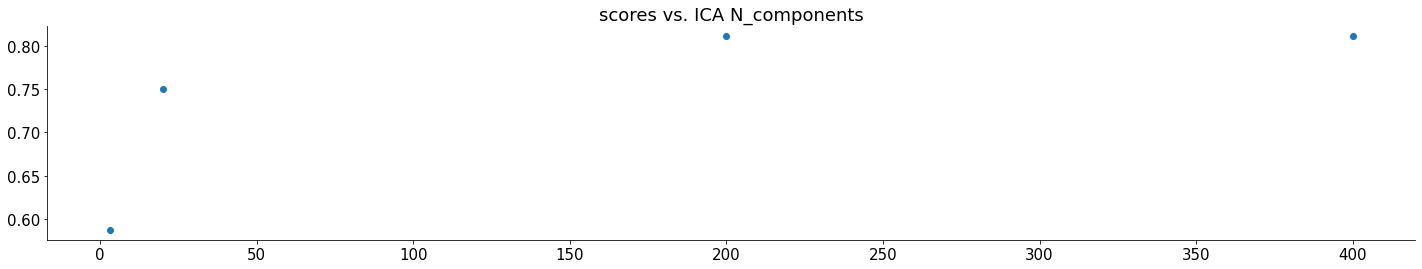

In [14]:
# plotting the scores vs components

plt.plot(components, val_scores, 'o')
plt.title('scores vs. ICA N_components')

Dimensionality reduction - GPFA (data imported from MATLAB)


In [6]:
#Tanvi - 10 AM EST Jun 22
#download GPFA reduced file (340 x 8 x 250) from MATLAB
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google'

Text(0.5, 0.98, 'Factors from 8-dim GPFA reduction')

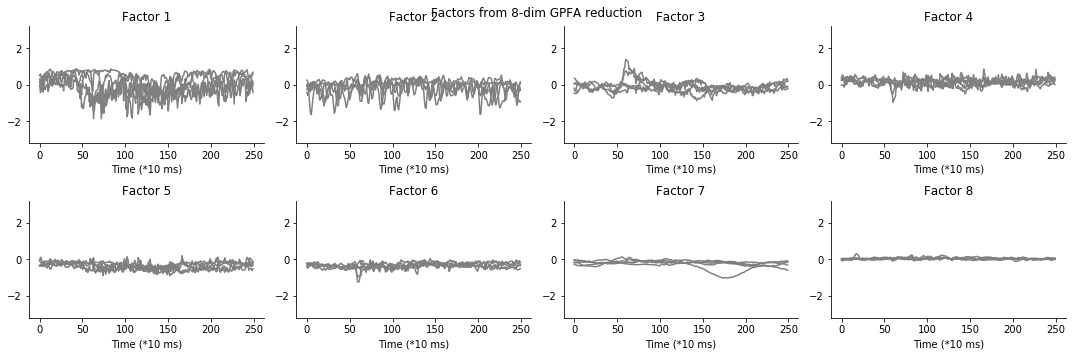

In [38]:
%matplotlib inline
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

gpfa_Y = loadmat('/Users/tanviranjan/Dropbox (HNL)/Motorlab/Tanvi/Neuromatch 2020/Project/gpfa_v0203/GPFA_reduced.mat')['gpfa_Y'];
#gpfa_Y = loadmat('GPFA_reduced.mat')['gpfa_Y']; # Use this for google colab

xx=np.squeeze(gpfa_Y[0:2]).shape; 

f=plt.figure(figsize=(15,5))
for ifa in range(8):
  plt.subplot(2,4,ifa+1), 
  for it in range(5):
    plt.plot(gpfa_Y[it][ifa],'grey'); 
  plt.ylim([-3.2,3.2]); plt.xlabel('Time (*10 ms)');
  plt.title('Factor %i' %(ifa+1))
plt.suptitle('Factors from 8-dim GPFA reduction')

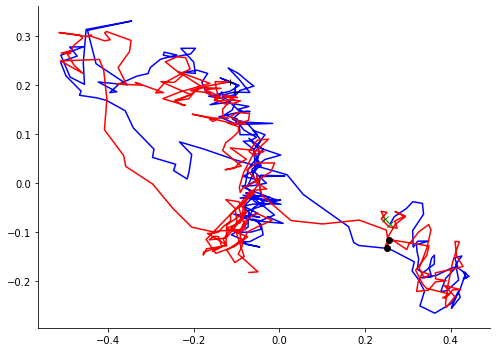

In [51]:
%matplotlib inline
Y=dat['response']; 
gy1 = np.mean(gpfa_Y[np.where(Y==-1)],axis=0); gy2 = np.mean(gpfa_Y[np.where(Y==1)],axis=0); 

# f = plt.figure(figsize=(7,5)); ax2 = fig.add_subplot(111, projection='3d')
# ax2.plot3D(gy1[0],gy1[1],gy1[2],'.-'); ax2.plot3D(gy2[0],gy2[1],gy2[2],'.-',color='red');
# ax2.scatter3D(gy1[0][0],gy1[1][0],gy1[2][0],'x',color='blue'); ax2.scatter3D(gy2[0][0],gy2[1][0],gy2[2][0],'x',color='red'); 

f=plt.figure(figsize=(7,5))
plt.plot(gy1[0],gy1[1],color='blue'); plt.plot(gy2[0],gy2[1],color='red'); 
plt.plot(gy1[0][0],gy1[1][0],'x',color='green');plt.plot(gy2[0][0],gy2[1][0],'x',color='green');
plt.plot(gy1[0][51],gy1[1][51],'o',color='black');plt.plot(gy2[0][51],gy2[1][51],'o',color='black')
plt.plot(gy1[0][131],gy1[1][131],'+',color='black');plt.plot(gy2[0][131],gy2[1][131],'+',color='black')

In [43]:
gy1[0][0]


0.25969015533847156

Classification of GPFA reduced data using Naive Bayes classifier

In [1]:
# determine weights (neurons to latent_state) from GPFA and what brain regions they correspond to
C=loadmat('GPFA_reduced (1).mat')['C'];

f = plt.figure(figsize=(20,10))

for ifa in range(len(C[0])):
  plt.subplot(3,3,ifa+1); plt.plot(np.abs(C[:,ifa]),marker='.');
  plt.ylim([0,0.15])

plt.show()

regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

gpfa_average_weight = np.empty(shape=(nareas,8),dtype='float64');
for iarea in range(nareas):
  gpfa_average_weight[iarea,:] = np.mean(np.abs(C[barea[:-1] == iarea,:]),axis=0);

f = plt.figure(figsize=(7,10))

for ifa in range(8):  
  plt.subplot(4,2,ifa+1); plt.bar(range(4),gpfa_average_weight[:,ifa]);

NameError: ignored

### Continue with plots

In [ ]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

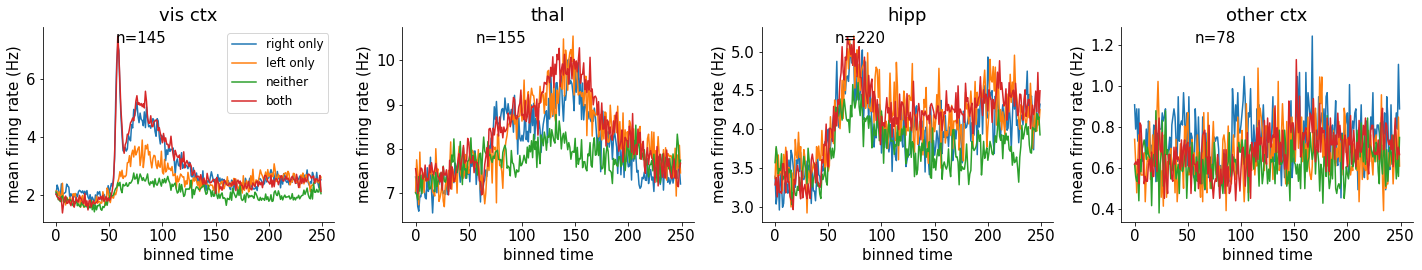

In [ ]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


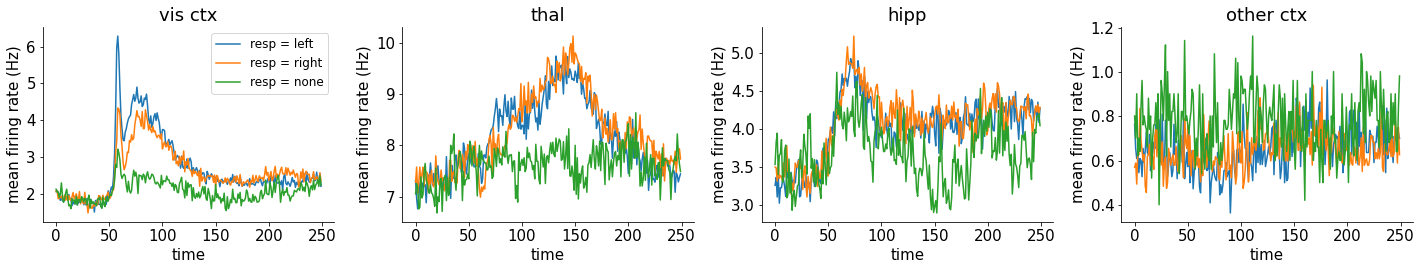

In [ ]:
#@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [ ]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

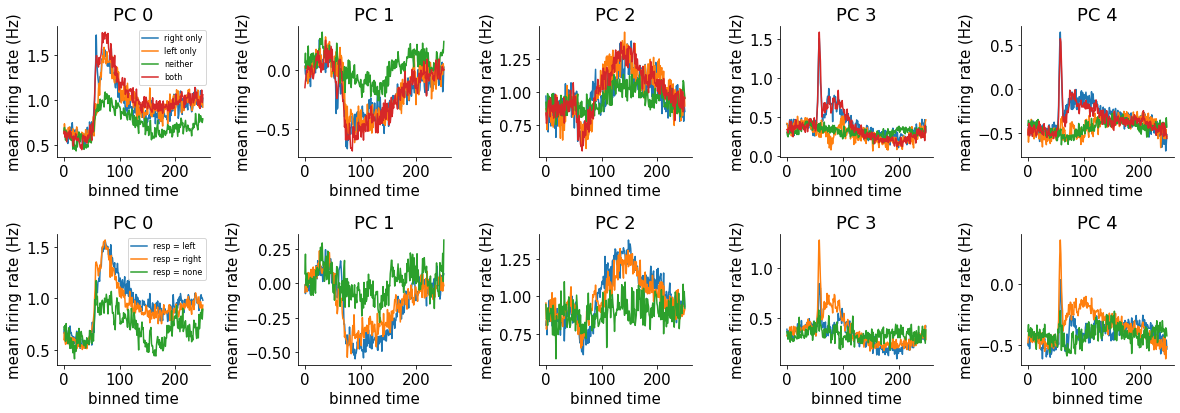

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

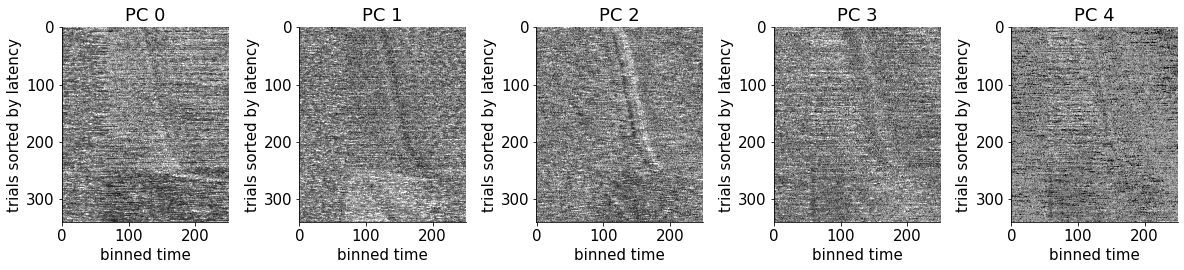

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

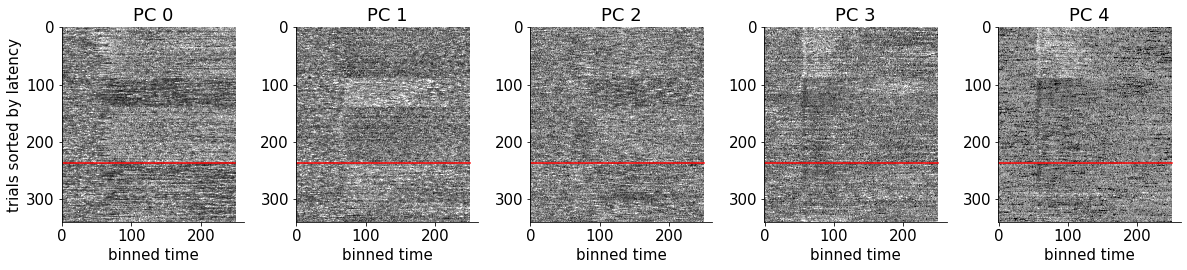

In [ ]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


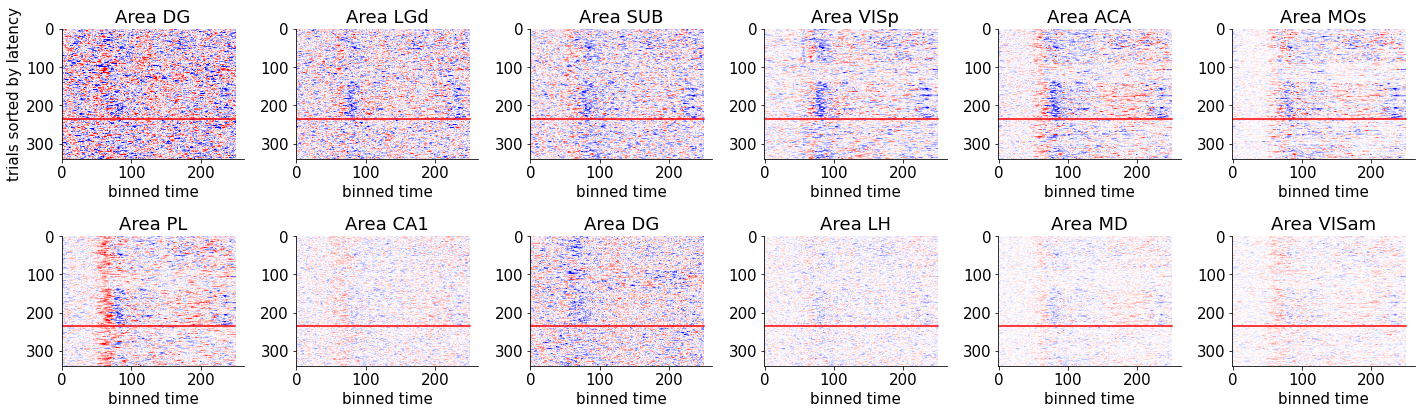

In [ ]:
# plot the LFP

is_correct = np.sign(response)==np.sign(vis_left-vis_right)
isort = np.argsort(-is_correct.astype('float32') + response/10) # sort by correct, and then by response

nwrong = np.sum(is_correct)
plt.figure(figsize=(20,6))
for j in range(len(dat['lfp'])):
  ax = plt.subplot(2,6,j+1)
  plt.imshow(dat['lfp'][j, isort], cmap = 'bwr', vmax = 50, vmin=-50, aspect='auto')
  plt.title('Area %s'%dat['brain_area_lfp'][j])
  
  plt.plot([0, NT], [nwrong, nwrong], 'r')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  


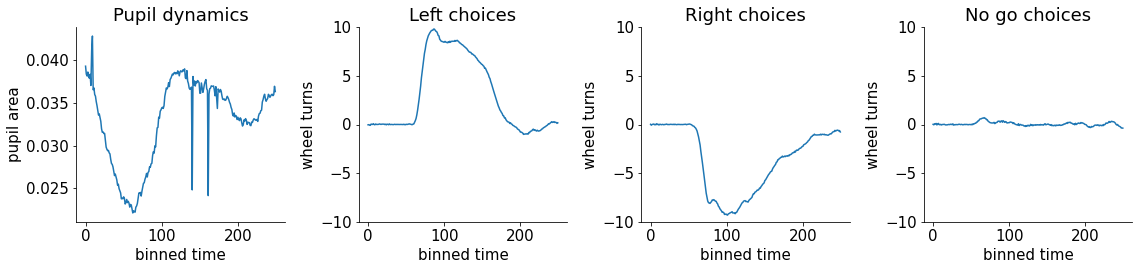

In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0));
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices');


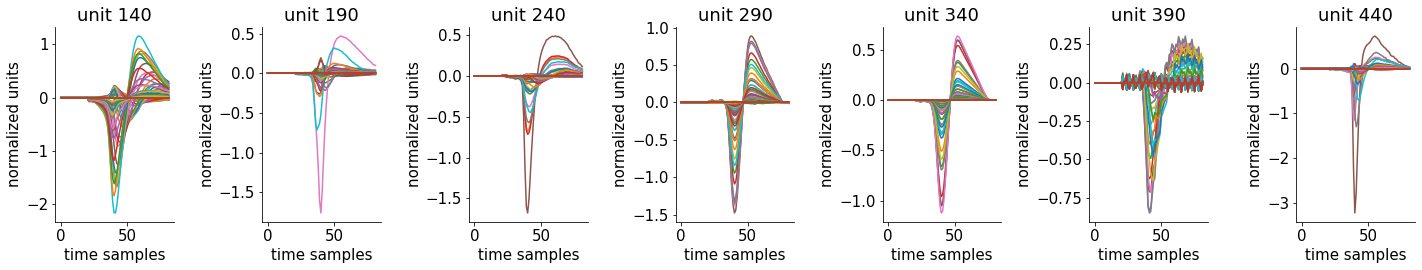

In [ ]:
# plot the spike waveforms for some neurons. Sometimes these can tell us what cell type the neuron is 
# (i.e. fast spiking interneurons have short waveforms)

for j in range(7):
  ax = plt.subplot(1,7,j+1)
  kk = 140 + j * 50
  wav = dat['waveform_w'][kk] @ dat['waveform_u'][kk]
  plt.plot(wav)
  ax.set(xlabel = 'time samples', title ='unit %d'%kk, ylabel = 'normalized units')

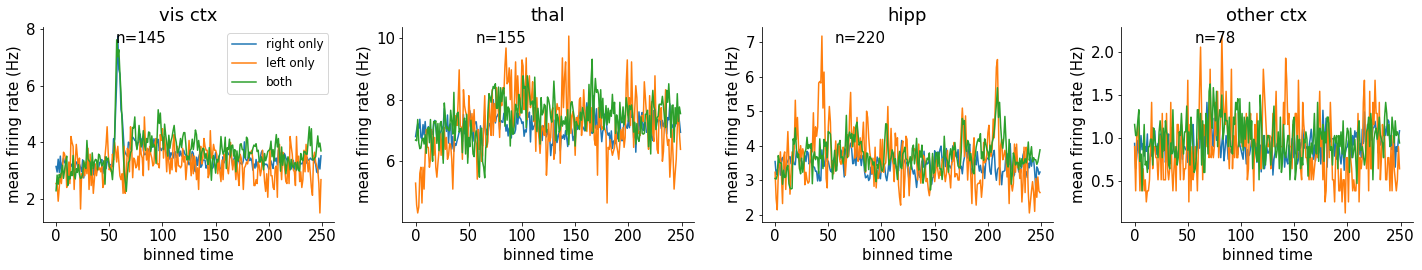

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')